## SPARC-4 mini-pipeline tools
# Bias and Flat-field calibrations

This notebook shows an example for combining a series of bias and flat exposures into the master calibration product of SPARC4 pipeline.

* Eder Martioli, LNA 10 Jun 2023

In [16]:
import os,sys
path_parent = os.path.dirname(os.getcwd())
# path_parent = "/Volumes/Samsung_T5/sparc4-pipeline/"
sys.path.append(path_parent)
import sparc4_product_plots as s4plt
import sparc4_pipeline_lib as s4pipelib

## User inputs

In [17]:
# set night directory name
NIGHTDIR = '20230503'
# set raw data root directory
DATADIR =  "/Volumes/Samsung_T5/Data/SPARC4/minidata/"
# set reduced data root directory
REDUCEDDIR = "/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced/"

# set SPARC4 channel
CHANNEL = 3  # 1, 2, 3 or 4

# whether or not to force reduction even if product already exists
FORCE = True

# get SPARC4 pipeline parameters
p = s4pipelib.init_s4_p(datadir=DATADIR,
                            reducedir=REDUCEDDIR,
                            nightdir=NIGHTDIR,
                            channels="{}".format(CHANNEL),
                            print_report=True)

***************************************
********* Night: 20230503 ***********
***************************************
Total number of images : 188
Night dir: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs1/20230503/
	Number of images in channel 1: 47
Night dir: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs2/20230503/
	Number of images in channel 2: 47
Night dir: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/
	Number of images in channel 3: 47
Night dir: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/
	Number of images in channel 4: 47
---------------------------------------
Total number of calibration images: 40
	Number of zero images: 20
		 5 zero images in channel 1
		 5 zero images in channel 2
		 5 zero images in channel 3
		 5 zero images in channel 4
	Number of dome flat images: 20
		 5 dome flat images in channel 1
		 5 dome flat images in channel 2
		 5 dome flat images in channel 3
		 5 dome flat images in channel 4
	Number of sky flat

## Define output product file names

Below are the default file names adopted by the pipeline, but one could use a different name. 

In [11]:
# set master bias product file name
p["master_bias"] = "{}/{}_s4c{}_MasterZero.fits".format(p['reduce_directories'][CHANNEL-1],NIGHTDIR,CHANNEL)
# set master flat product file name
p["master_flat"] = "{}/{}_s4c{}_MasterDomeFlat.fits".format(p['reduce_directories'][CHANNEL-1],NIGHTDIR,CHANNEL)

# Run master calibration

In [12]:
# calculate master bias and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=p['zeros'][CHANNEL-1], 
                                     output=p["master_bias"], 
                                     obstype='bias', 
                                     data_dir=DATADIR, 
                                     reduce_dir=p['reduce_directories'][CHANNEL-1], 
                                     force=FORCE)

2023-06-12 17:51:11,983 astropop - INFO - reading file 0 from 5: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004629_zero.fits  [file_collection]
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:93: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:38: FutureWarning: elementwise comparison failed; ret

bias files: 5
gain: 0.8 electron / adu
processing frame 1 of 5
processing frame 2 of 5
processing frame 3 of 5
processing frame 4 of 5
processing frame 5 of 5


2023-06-12 17:51:15,008 astropop - INFO - Combining 5 images with median method.  [imcombine]


Normalization mean value: 400.49094467163076 electron


In [13]:
# calculate master dome flat and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=p['dflats'][CHANNEL-1], 
                                     output=p["master_flat"], 
                                     obstype='flat', 
                                     data_dir=DATADIR, 
                                     reduce_dir=p['reduce_directories'][CHANNEL-1], 
                                     normalize=True, 
                                     force=FORCE)

2023-06-12 17:51:15,585 astropop - INFO - reading file 0 from 5: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_001453_dflat.fits  [file_collection]
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:93: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:38: FutureWarning: elementwise comparison failed; re

flat files: 5
gain: 0.8 electron / adu
processing frame 1 of 5
processing frame 2 of 5
processing frame 3 of 5
processing frame 4 of 5
processing frame 5 of 5


2023-06-12 17:51:20,050 astropop - INFO - Combining 5 images with median method.  [imcombine]


Normalization mean value: 25345.872422714536 electron


# Produce plots

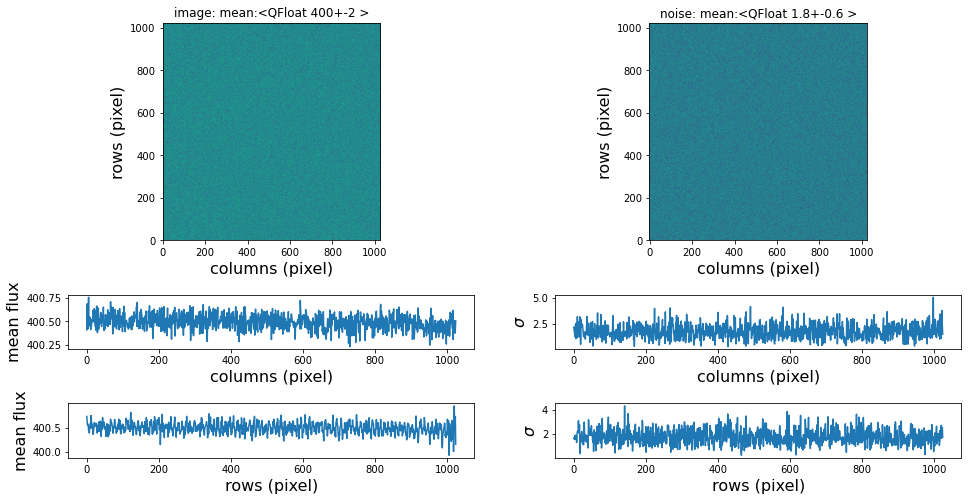

In [14]:
# plot master bias
s4plt.plot_cal_frame(p["master_bias"], percentile=99.5, combine_rows=True, combine_cols=True)

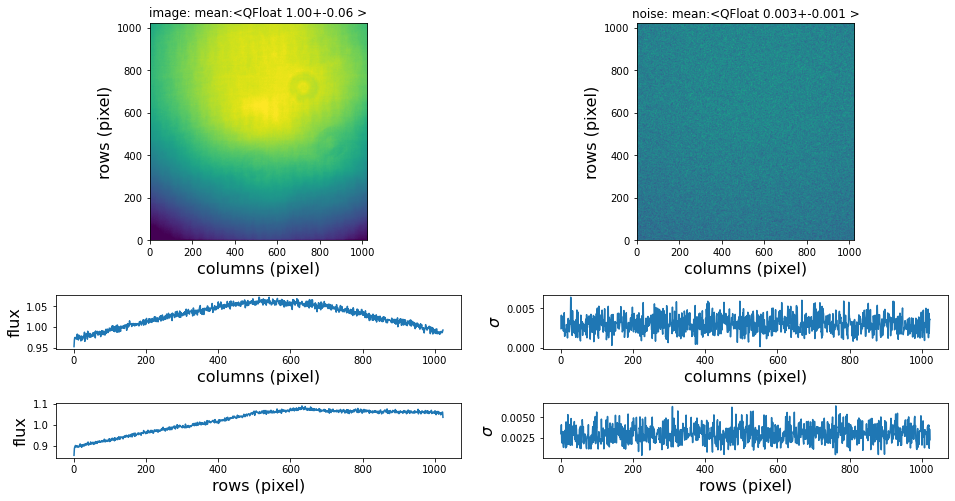

In [15]:
# plot master flat
s4plt.plot_cal_frame(p["master_flat"], percentile=99.5, xcut=512, ycut=512)